# Facial Keypoint Recognition #
*a MIDS W207 final project by Harry Xu, Noah Randolph, and Chet Gutwein*

From the www.kaggle.com competition database, we decided as a group to tackle the challenge of generating a predictive model for facial keypoints from the image of a face of a human. 
https://www.kaggle.com/c/facial-keypoints-detection

## Goal ##
For this challenge the goal is to acheive the lowest root mean squared error (RMSE) classifying facial keypoint locations in digital grayscale images. Facial keypoints recognition is a crucial component of a broad set of applications that utilize digital faces, such as medical diagnosis research, biometric security screening, and social media camera apps. Training and tuning models for keypoint recognition is computationally demanding due to the multiple facial points to classify, the large number of total features (each image pixel is a feature), continuous data in each feature, and the need for a large training set.
The x and y position of 15 facial keypoints in an image result in 30 columns of label names and 30 points with pixel locations to correctly classify for each test image.
The text below documents our efforts to acheive as low of a RMSE as possible. To run the code, you should download the data files here.

## Step 0. Import Applicable Libraries and Set Initial Settings ##

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sb
import math
from IPython.display import display, clear_output
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.filters import gaussian_filter

## need to pip install this to read in images, not necessary except for last cell
import imageio

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# set random seed to achieve same results each time
np.random.seed(23)

## Step 1. Create Object with Initial Methods
We decided to create an object to hold initial value including initial model attempts and other critical steps to creating our model, evaluating the model, preprocessing data features, and creating the submission file. We will elaborate on different aspects of the object throughout this notebook. 
### Initial Values and Calls
For the .csv data files, we used the pandas module to read these into Python as a DataFrame, which will allow us to easily work with the data using both pandas and numpy methods.
### Training, Development, and Test Data
It is critical in machine learning for model development to be able to test the performance of each model interation. In order to do this, it is important to preserve a portion of the training data set (typically about 20-30%) and use it to evaluate model performance.

As a rule, the test data should not be evaluated until a final model has been generated. In our case, we are not at risk of introducing bias into our model with test data because we do not have access to the data labels.

In our object, we are initializing our data by removing 1000 of the 7069 training samples. Additionaly, the data has then been randomly re-ordered using numpy's shuffle method.

In [2]:
class FacialKeypoints(object):
    
    def __init__(self):
        self.train_csv = pd.read_csv("../p_final/training.csv")
        self.test_csv = pd.read_csv("../p_final/test.csv")
        self.sample_csv = pd.read_csv("../p_final/SampleSubmission.csv")
        self.ID_csv = pd.read_csv("../p_final/IdLookupTable.csv")
        self.label_names = self.train_csv.columns.tolist()[:-1]
        self.dev_data_n, self.dev_labels_n, self.train_data_n, self.train_labels_n = self.create_training(self.train_csv)
        self.dev_data, self.dev_labels, self.train_data, self.train_labels = self.create_training(self.train_csv, nans=False)
        self.train_data_f, self.train_labels_f = self.flip_data(self.train_data), self.flip_labels(self.train_labels)
        self.test_data, _ = self._parse_data(self.test_csv)
    
    def create_training(self, train_csv, dev_size=1000, nans=True):
        if nans == False:
            train_csv = train_csv.dropna()
        data, labels = self._parse_data(train_csv)
        shuffle = np.random.permutation(np.arange(data.shape[0]))        
        data, labels              = data[shuffle], labels[shuffle]       # Shuffle the data
        dev_data, dev_labels      = data[:dev_size], labels[:dev_size]   # Splitting into dev and training
        train_data, train_labels  = data[dev_size:], labels[dev_size:]
        return dev_data, dev_labels, train_data, train_labels
    
    def plot_example(self, data, label, predicted_label=np.nan, legend=True):
        plt.imshow(data.reshape(96, 96), cmap='gray')
        plt.scatter(label[0::2], label[1::2], c='red', marker='x', label='actual')
        if np.all(np.isfinite(predicted_label)):
            plt.scatter(predicted_label[0::2], predicted_label[1::2], c='blue', marker='x', label='predicted')
        plt.axis('off')
        if legend:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
        return
    
    def score(self, y_pred, y_actual):
        return np.sqrt(mean_squared_error(y_actual, y_pred))
    
    def blur_data(self, data):
        data = data.reshape(data.shape[0], int(data.shape[1]**0.5), -1) 
        data = np.array([np.roll(np.roll(data, horizontal, axis=1), 
                                               vertical  , axis=2) 
                         for vertical in range(-1,2) for horizontal in range(-1,2)]
                       ).mean(axis=0)     
        return data.reshape(data.shape[0], -1)
    
    def submission_gen(self, predictions, file_name):
        df = pd.DataFrame(predictions, columns=self.train_csv.columns[:-1])
        pos = []
        for index, row in self.ID_csv.iterrows():
            pos.append((row['RowId'], df.iloc[row.ImageId - 1][row.FeatureName]))
        sub = pd.DataFrame(pos, columns=('RowId', 'Location'))
        sub.to_csv("./" + file_name + ".csv", index=False)
        return
    
    ## Various Methods to Create More Training Examples
    def average_nans(self, train_labels):
        df = pd.DataFrame(train_labels)
        return df.fillna(df.mean()).values
    
    def flip_data(self, train_data):
        num_images = train_data.shape[0]
        train_data = train_data.reshape(num_images, 96, 96)[..., ::-1].flatten()
        return train_data.reshape(num_images, 9216)
    
    def flip_labels(self, train_labels):
        df = pd.DataFrame(train_labels.copy(), columns=self.label_names)
        df.loc[:, df.columns.str.contains('_x')] = df.loc[:, df.columns.str.contains('_x')].applymap(self._flip_axis)
        return df.values
        
    ## Helper Functions
    def _flip_axis(self, value, axis=47):
        if value >= axis:
            return axis - np.abs(value - axis)
        else:
            return axis + np.abs(value - axis)
    
    def _parse_data(self, data):
        labels = data.loc[:, data.columns != 'Image'].values   # column Image is the image data
        data = data['Image'].str.split()                       # image data comes as one long string
        data = np.vstack(data.apply(lambda row: np.asarray([int(n) for n in row])).values)
        data = data/255.0                                      # Rescale grayscale values to [0,1].
        return data, labels
    
    def rgb2gray(self, rgb):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray
    
    pass

## Initialize the Object

In [3]:
self = FacialKeypoints()

## Missing Labels

We noticed that there are many examples that are missing a full label set. Out of the total 6049 examples, only 1140 have the full set of labels. Here is the percentage break out of each label.

The most simple way to get around the issue of these missing labels is to drop all of the training samples that contain mission or 'NaN' values. However, this leaves us with only a fraction of the training samples that we have at our disposal! The initial models we ran were with this smaller, but complete, set of training data. We'll later discuss other (better) options.

In [4]:
(self.train_csv.loc[:, self.train_csv.columns != 'Image'].count()/len(self.train_csv.index)).round(3)

left_eye_center_x            0.999
left_eye_center_y            0.999
right_eye_center_x           0.998
right_eye_center_y           0.998
left_eye_inner_corner_x      0.322
left_eye_inner_corner_y      0.322
left_eye_outer_corner_x      0.322
left_eye_outer_corner_y      0.322
right_eye_inner_corner_x     0.322
right_eye_inner_corner_y     0.322
right_eye_outer_corner_x     0.322
right_eye_outer_corner_y     0.322
left_eyebrow_inner_end_x     0.322
left_eyebrow_inner_end_y     0.322
left_eyebrow_outer_end_x     0.316
left_eyebrow_outer_end_y     0.316
right_eyebrow_inner_end_x    0.322
right_eyebrow_inner_end_y    0.322
right_eyebrow_outer_end_x    0.317
right_eyebrow_outer_end_y    0.317
nose_tip_x                   1.000
nose_tip_y                   1.000
mouth_left_corner_x          0.322
mouth_left_corner_y          0.322
mouth_right_corner_x         0.322
mouth_right_corner_y         0.322
mouth_center_top_lip_x       0.323
mouth_center_top_lip_y       0.323
mouth_center_bottom_

## Plot Examples
In order to better understand the dataset, we have used the 'plot_example' function that we wrote into our object to plot some images with labeled keypoints. Below are six example plots for images that do not have labels for all 15 facial keypoints.

There appears to be a large number of training data samples that include only 'left_eye_center', 'right_eye_center', 'nose_tip', and 'mouth_center_bottom'.

There is also some variation in the resolution of the images as some are clearly blurry in comparison to others.

Another thing that we can see from looking at the plotted values, is that there is some subjectivity to the training labels. Do you notice any labels that are off? It appears that some are not quite accurate. For now, there is nothing we will do about this other than make note of it.

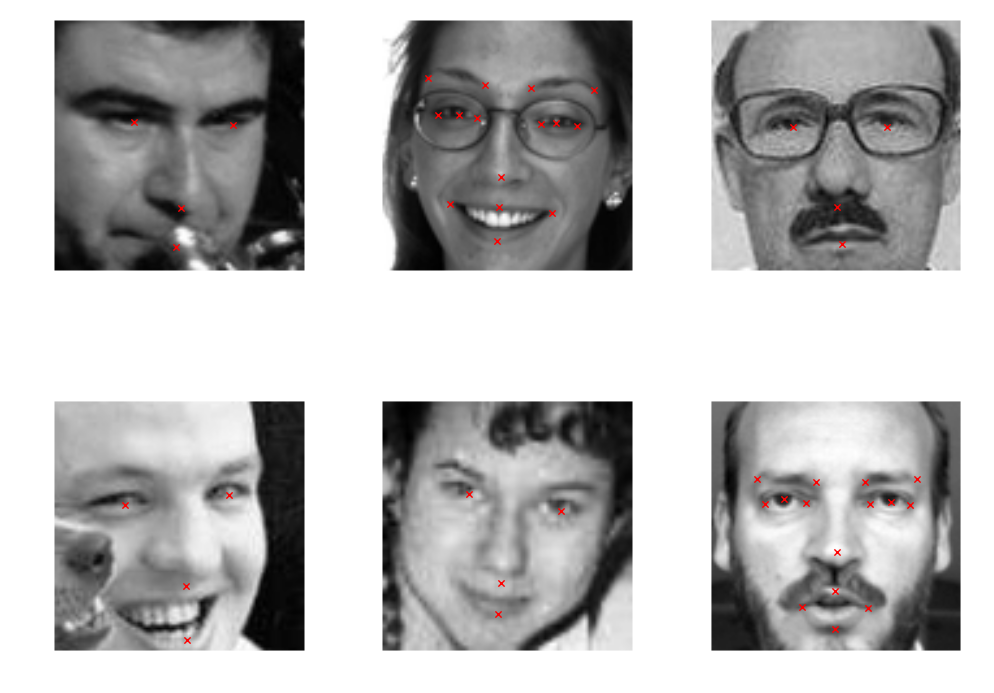

In [5]:
for n in range(1, 7):
    plt.subplot(2, 3, n)
    self.plot_example(self.train_data_n[n], self.train_labels_n[n], legend=False) 

#### Plot Examples From Complete Labels

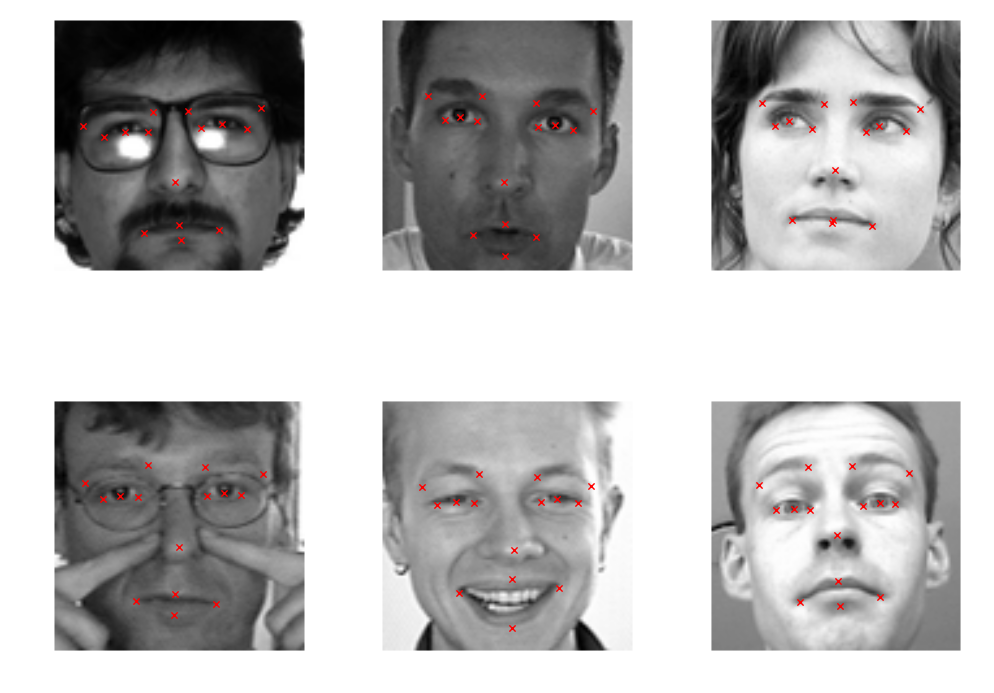

In [6]:
for n in range(1, 7):
    plt.subplot(2, 3, n)
    self.plot_example(self.train_data[n], self.train_labels[n], legend=False) 

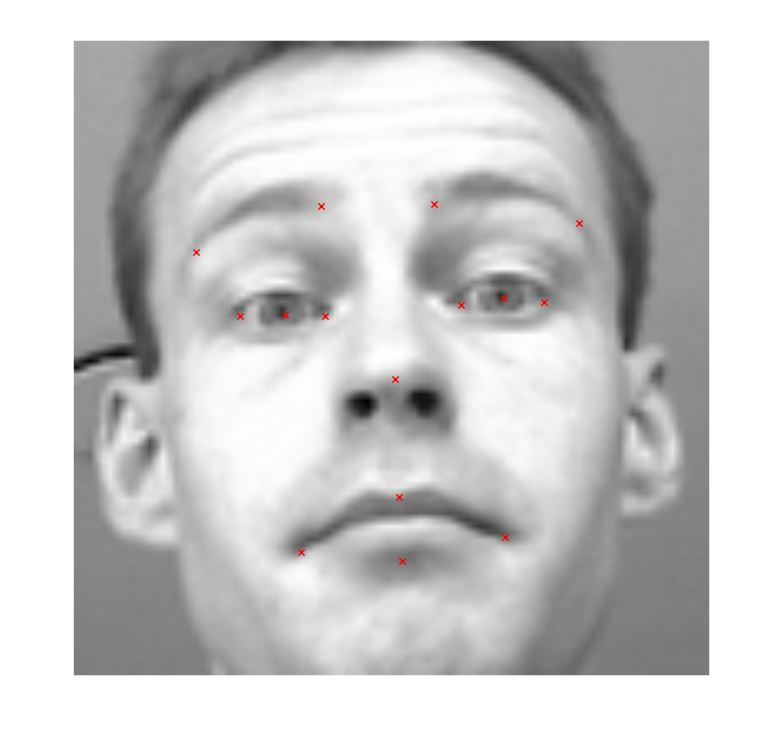

In [7]:
self.plot_example(self.train_data[n], self.train_labels[n], legend=False)

## Feature Engineering
Earlier we identified a pretty big problem which is that most of our training data has incomplete labels. Having quality and abundant training data is absolutely essential for model performance, thus, we will be discussing a few feature engineering techniques that we used to help boost our training data.

### Blurring the Image
We attempt to improve test data scores by reducing the severity of overfitting to the training data. Thus, we applied a blurring effect to the input images by writing a preprocessing function that takes a pixel value and replaces it with a weighted average of all neighboring pixel values. 

An example of the blurring effect on an image using our preprocessor is presented below. Reference the object code from earlier for a closer look at the blurring algorithm.

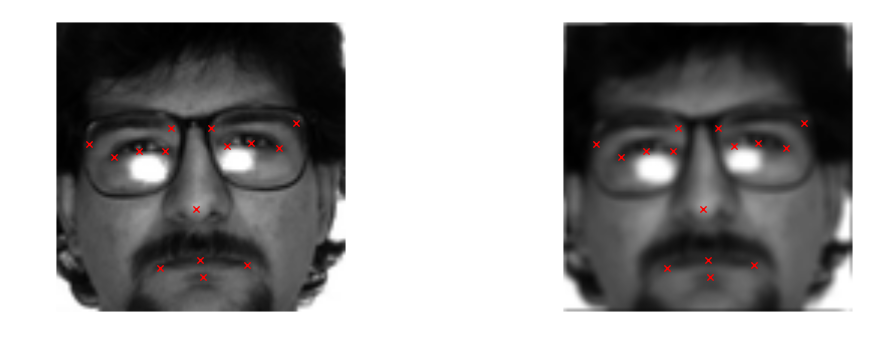

In [8]:
plt.subplot(2, 2, 1)
self.plot_example(self.train_data[1], self.train_labels[1], legend=False)
plt.subplot(2, 2, 2)
self.plot_example(self.blur_data(self.train_data)[1], self.train_labels[1], legend=False)

### Filling Missing Labels
Earlier we mentioned we dropped the incomplete training samples. The next step would be to replace any 'NaN' labels with the average value for these labels from the label training samples. An example is plotted below, the image on the right hand side having the added labels using average values.

Looking at the example, we must interpret and understand that by introducing the average values we are biasing our model with these values. The added labels on the right hand side are being considering by our model as accurate and used to tune the model, but we can see that some labels are pretty far off.

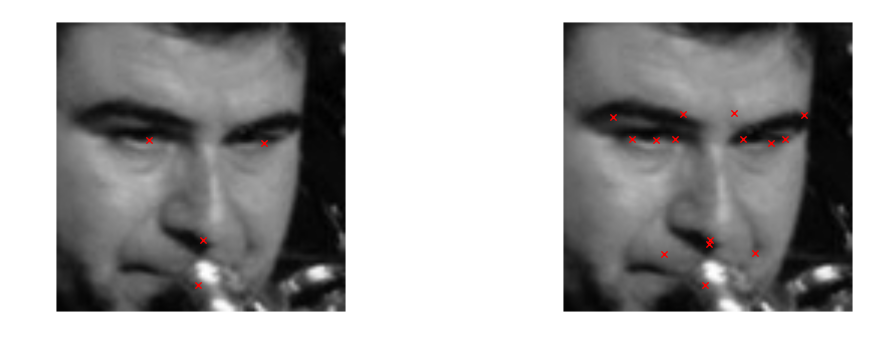

In [9]:
plt.subplot(2, 2, 1)
self.plot_example(self.train_data_n[1], self.train_labels_n[1], legend=False)
plt.subplot(2, 2, 2)
self.plot_example(self.train_data_n[1], self.average_nans(self.train_labels_n)[1], legend=False)

### Flipping the Image
Another method to overcome our scarce set of training samples is to artificially create more of them. One way to do this is to flip each image on its y-axis to create a mirror image which will then act as a completely separate training sample. We performed this transformation as well as the data labels and were able to double the size of our training data!

See the plot below for an example of a flipped sample.

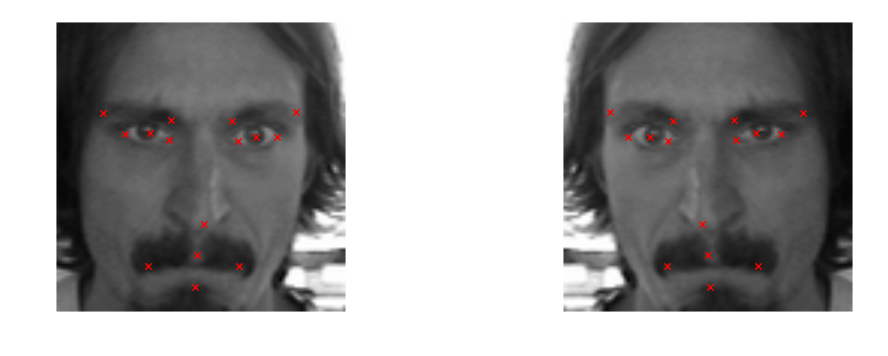

In [10]:
plt.subplot(2, 2, 1)
self.plot_example(self.train_data[0], self.train_labels[0], legend=False)
plt.subplot(2, 2, 2)
self.plot_example(self.train_data_f[0], self.train_labels_f[0], legend=False)

## Model 1, K- Nearest Neighbors
We decided to try a simple classifier to understand what is possible before jumping straight to the more advanced and more complicated options. Our first attempt used the K Nearest Neighbors algorithm. The basic idea here is to find the closest 'k' examples to that of the input sample and then apply the label from the 'k' nearest neighbors to the sample. We used the 'scikit-learn' package to build the model and GridSearchCV to perform hyperparameter tuning. 

Note: each label output is a regression value as opposed to a classifier - documentation from scikit-learn:
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

#### Model 1.1 K-NN: using only the training data with complete set of labels
We used GridSearch to determine that the optimal value for n_neighbors=3

In [12]:
data = self.train_data
labels = self.train_labels

print ('Our training set is size ' + str(data.shape[0]))

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

y_pred = knn.predict(self.dev_data)
print ('RMSE on Dev Data of ', self.score(self.dev_labels, y_pred))

Our training set is size 1140
RMSE on Dev Data of  2.56996091945


#### Model 1.2: K-NN using training data with missing labels filled by average

In [13]:
data = self.train_data_n
labels = self.average_nans(self.train_labels_n)

print ('Our training set is size ' + str(data.shape[0]))

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

y_pred = knn.predict(self.dev_data) 
print ('RMSE on Dev Data of ', self.score(self.dev_labels, y_pred))

Our training set is size 6049
RMSE on Dev Data of  1.86061995092


#### Model 1.3: K-NN using blurring and average _nans_

blur_data shifts the image 1 pixel in each direction and takes the mean, effectively returning a blurred image

average_nans replaces missing values/nans with the average value of that feature

In [39]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

print ('Our training set now has increased to ' + str(data.shape[0]))

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

y_pred = knn.predict(self.dev_data) 
print ('RMSE on Dev Data of ', self.score(self.dev_labels, y_pred))

Our training set now has increased to 6049
RMSE on Dev Data of  1.82254721331


#### RMSE by Label
After seeing how our models have performed overall with K Nearest Neighbhors, let's take a look at how each individual label performs.

In [15]:
pd.DataFrame(np.sqrt(mean_squared_error(self.dev_labels, y_pred, multioutput='raw_values')), 
             columns=['RMSE'], index=self.label_names).sort_values('RMSE', ascending=False)

,RMSE
nose_tip_y,3.024229
mouth_center_bottom_lip_y,2.605217
mouth_center_top_lip_y,2.578482
mouth_left_corner_y,2.394495
mouth_right_corner_y,2.289124
mouth_left_corner_x,2.178618
mouth_right_corner_x,2.149628
right_eyebrow_outer_end_y,2.147477
left_eyebrow_outer_end_y,2.087928
left_eyebrow_outer_end_x,1.898402


#### Analyzing Error in Predictions
We are going to look at a histogram and plot the three best performing (by RMSE) and three worst performing (by RMSE).

[[903, 0.3016508543566786], [36, 0.31907553676672878], [879, 0.33870648335639225], [835, 0.36880332522912779], [125, 0.37923699728823357]]


(array([  59.,  159.,  170.,  126.,   95.,   73.,   51.,   41.,   46.,
          36.,   29.,   27.,   17.,   17.,   12.,   10.,    8.,    5.,
           4.,    3.,    5.,    3.,    1.,    1.,    0.,    0.,    2.]),
 array([ 0.30165085,  0.53074646,  0.75984207,  0.98893768,  1.21803328,
         1.44712889,  1.6762245 ,  1.9053201 ,  2.13441571,  2.36351132,
         2.59260693,  2.82170253,  3.05079814,  3.27989375,  3.50898935,
         3.73808496,  3.96718057,  4.19627617,  4.42537178,  4.65446739,
         4.883563  ,  5.1126586 ,  5.34175421,  5.57084982,  5.79994542,
         6.02904103,  6.25813664,  6.48723225]),
 <a list of 27 Patch objects>)

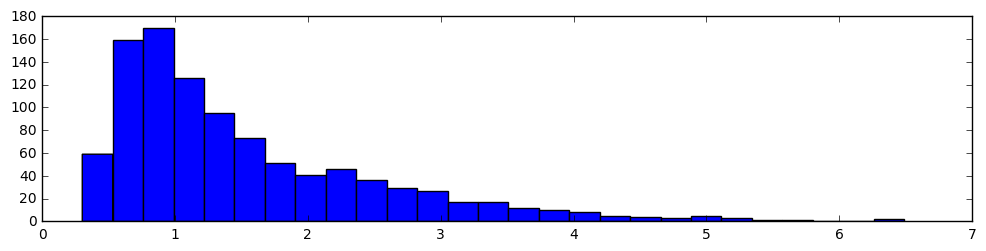

In [40]:
## RMSE by sample
rmse_1_1 = []
for i in range(len(self.dev_labels)):
    rmse_ = (self.score(self.dev_labels[i], y_pred[i]))
    rmse_1_1.append([i, rmse_]) # list of lists of form [index, rmse]
rmse_1_1.sort(key=lambda x: x[1])
plt.subplot(3,1,1)
print(rmse_1_1[0:5])
plt.hist([n[1] for n in rmse_1_1], bins='auto')

903 0.301650854357
36 0.319075536767
879 0.338706483356
708 6.48723224539
241 6.28900623766
585 5.63467529153


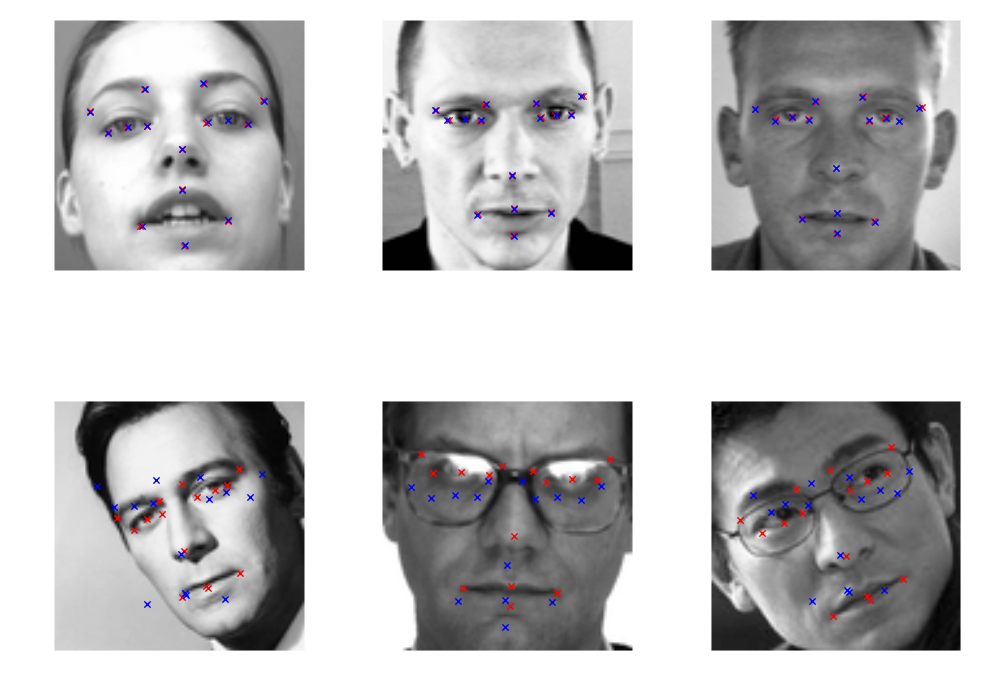

In [41]:
for n in range(1, 4):
    plt.subplot(2, 3, n)
    print(rmse_1_1[n-1][0], rmse_1_1[n-1][1])
    self.plot_example(self.dev_data[rmse_1_1[n-1][0]], self.dev_labels[rmse_1_1[n-1][0]], y_pred[rmse_1_1[n-1][0]], legend=False)
for n in range(1, 4):
    plt.subplot(2, 3, n+3)
    print(rmse_1_1[n*-1][0], rmse_1_1[n*-1][1])
    self.plot_example(self.dev_data[rmse_1_1[n*-1][0]], self.dev_labels[rmse_1_1[n*-1][0]], y_pred[rmse_1_1[n*-1][0]],legend=False)

#### Plot a Prediction

RMSE of 1.06332539756


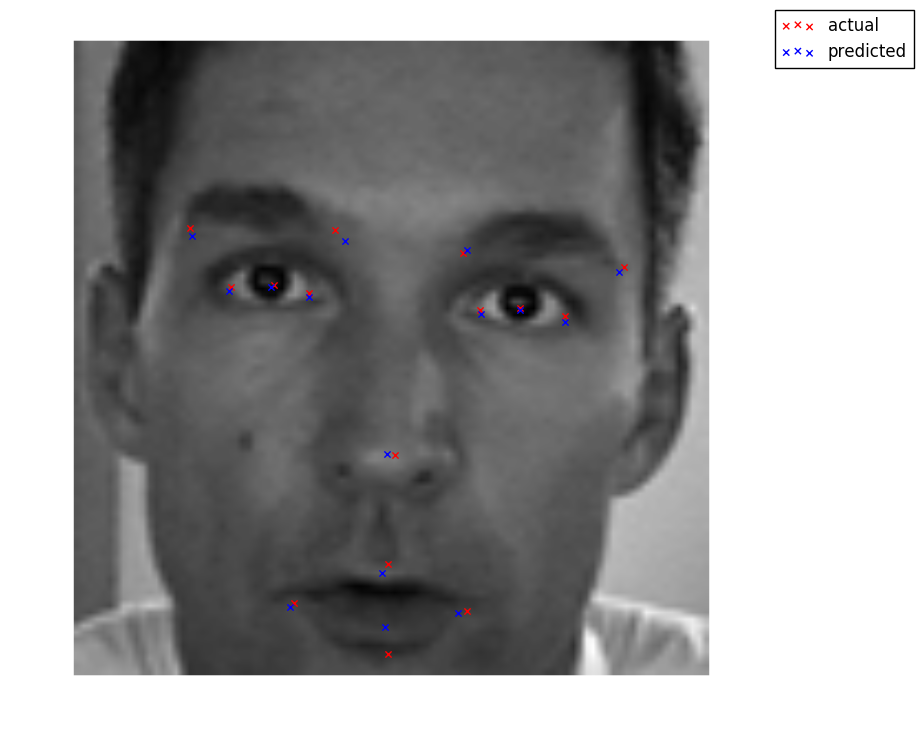

In [16]:
example_num = 25
print ('RMSE of '+ str((self.score(self.dev_labels[example_num], y_pred[example_num]))))

self.plot_example(self.dev_data[example_num], self.dev_labels[example_num], y_pred[example_num])

#### Using Flipped Images to Extend Our Training Data
Now we are combining the artificial training data generated by the face flip to the training data set.

In [18]:
data = np.concatenate((self.train_data, self.train_data_f))
labels = np.concatenate((self.train_labels, self.train_labels_f))

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

y_pred = knn.predict(self.dev_data) 
print ('RMSE on Dev Data of ', self.score(self.dev_labels, y_pred))

RMSE on Dev Data of  9.84954914127


## Model 2: Neural Network using SKLearn - MLPRegressor

http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

Scikit Learn's multi-layer Perceptron Regressor provides a simple version of a Neural Network model. We start using the default options. This is really convenient because we have a total of 30 labels for our data output, which has proven to be difficult with initial attempts using other modeling options (such as TensorFlow). As with the K-NN model we selected the Regressor version. In addition, to MLPRegressor, ttempts with Tensorflow can be found in Appendix B.

Defaults for MLPRegressor:

 * 1 hidden layer with 100 neurons
 * Activation function: relu’, the rectified linear unit function, returns f(x) = max(0, x)
 * Optimizer: adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
 * many other parameters to look at

#### Some additional feature engineering ##
From scikit-learn's preprocessing module, we used to StandardScaler to normalize feature input (i.e. pixel) values for the MLP model.

### Model 2.1: MLPRegressor with defaults...
* Trained only on the completely labeled examples
* Two hidden layers (1000, 500)
* We used early_stopping to make training faster and also to avoid overfitting

In [19]:
data = self.train_data
labels = self.train_labels

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True, verbose=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))

Iteration 1, loss = 8.28682371
Validation score: -6.559384
Iteration 2, loss = 2.88234829
Validation score: -2.861513
Iteration 3, loss = 1.73787767
Validation score: -1.564985
Iteration 4, loss = 1.15248183
Validation score: -1.568344
Iteration 5, loss = 0.95069863
Validation score: -0.829381
Iteration 6, loss = 0.77931894
Validation score: -0.562064
Iteration 7, loss = 0.62228628
Validation score: -0.283144
Iteration 8, loss = 0.47440983
Validation score: -0.150297
Iteration 9, loss = 0.45822266
Validation score: 0.060078
Iteration 10, loss = 0.34545572
Validation score: 0.035442
Iteration 11, loss = 0.30444523
Validation score: 0.100070
Iteration 12, loss = 0.27998862
Validation score: 0.185122
Iteration 13, loss = 0.23151991
Validation score: 0.221991
Iteration 14, loss = 0.21651836
Validation score: 0.249486
Iteration 15, loss = 0.21049740
Validation score: 0.289399
Iteration 16, loss = 0.18903588
Validation score: 0.188575
Iteration 17, loss = 0.20356314
Validation score: 0.16739

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [20]:
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
print ('RMSE on Dev Data of ', self.score(self.dev_labels, label_scaler.inverse_transform(y_pred)))

RMSE on Dev Data of  2.59821524106


#### Model 2.2: MLPRegressor using training data with missing Labels filled by average

In [21]:
data = self.train_data_n
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [22]:
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
print ('RMSE on Dev Data of ', self.score(self.dev_labels, label_scaler.inverse_transform(y_pred)))

RMSE on Dev Data of  2.60572594238


#### Model 2.3: MLPRegressor using blurring and average _nans_

In [23]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp_blurr = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp_blurr.fit(data_scaler.transform(data), label_scaler.transform(labels))   

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(1000, 500), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [24]:
y_pred = mlp_blurr.predict(data_scaler.transform(self.dev_data))
print ('RMSE on Dev Data of ', self.score(self.dev_labels, label_scaler.inverse_transform(y_pred)))

RMSE on Dev Data of  2.3807301847


#### Parameter Optimization
The MLPRegressor algorithm offers many different parameters from which to tune the model. Using gridSearchCV, we attempted to optimize the following parameters:
* hidden layers
* initial learning rate

In [43]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

# build the regressor
mlp = MLPRegressor(hidden_layer_sizes=(80, 80), activation='relu', solver='sgd', alpha=0.0001, batch_size='auto', 
             learning_rate='constant', learning_rate_init=0.001, max_iter=200, shuffle=True, 
             random_state=None, tol=0.001, verbose=False, early_stopping=True)

# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# use a full grid over all parameters
param_grid = {"hidden_layer_sizes": [(80,80), (90,90), (100,100)],
              "learning_rate_init": [0.00010, 0.00012]}

# run grid search
grid_search = GridSearchCV(mlp, param_grid=param_grid, n_jobs=-1, verbose = 0)
start = time.time()
grid_search.fit(data_scaler.transform(data), label_scaler.transform(labels))

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)




GridSearchCV took 575.48 seconds for 6 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.225 (std: 0.012)
Parameters: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.00012}

Model with rank: 2
Mean validation score: 0.221 (std: 0.014)
Parameters: {'hidden_layer_sizes': (90, 90), 'learning_rate_init': 0.0001}

Model with rank: 3
Mean validation score: 0.218 (std: 0.004)
Parameters: {'hidden_layer_sizes': (90, 90), 'learning_rate_init': 0.00012}

Model with rank: 4
Mean validation score: 0.212 (std: 0.005)
Parameters: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.0001}

Model with rank: 5
Mean validation score: 0.210 (std: 0.016)
Parameters: {'hidden_layer_sizes': (80, 80), 'learning_rate_init': 0.00012}

Model with rank: 6
Mean validation score: 0.205 (std: 0.010)
Parameters: {'hidden_layer_sizes': (80, 80), 'learning_rate_init': 0.0001}



#### Fit, Predict, and Score Using Optimized Parameter Model

In [44]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', alpha=0.0001, batch_size='auto', 
             learning_rate='constant', learning_rate_init=0.00012, max_iter=200, shuffle=True, 
             random_state=None, tol=0.0001, verbose=False, early_stopping=False)

mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))   

y_pred = mlp.predict(data_scaler.transform(self.dev_data))
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

1.7789600022280962

[[902, 0.65526676022888686], [355, 0.68694836498950884], [269, 0.70760826391650644], [343, 0.74632947350510448], [479, 0.7518739708138219]]


(array([  11.,   60.,  101.,  137.,  106.,  129.,  106.,   64.,   58.,
          49.,   46.,   33.,   25.,   23.,    8.,    4.,   10.,    6.,
           3.,    5.,    1.,    2.,    4.,    1.,    2.,    1.,    1.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.,    0.,    0.,    1.,    1.]),
 array([ 0.65526676,  0.80452281,  0.95377886,  1.10303491,  1.25229095,
         1.401547  ,  1.55080305,  1.7000591 ,  1.84931515,  1.9985712 ,
         2.14782725,  2.2970833 ,  2.44633934,  2.59559539,  2.74485144,
         2.89410749,  3.04336354,  3.19261959,  3.34187564,  3.49113168,
         3.64038773,  3.78964378,  3.93889983,  4.08815588,  4.23741193,
         4.38666798,  4.53592402,  4.68518007,  4.83443612,  4.98369217,
         5.13294822,  5.28220427,  5.43146032,  5.58071636,  5.72997241,
         5.87922846,  6.02848451,  6.17774056,  6.32699661,  6.47625266,
         6.62550871,  6.77476475]),
 <a list of 41 Patch objects>)

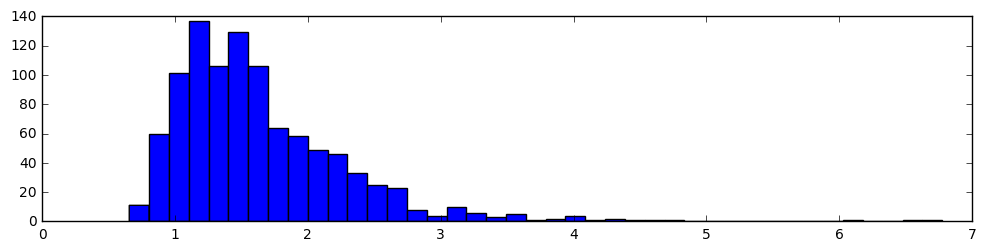

In [46]:
## RMSE by sample
y_pred = label_scaler.inverse_transform(y_pred)
rmse_2_4 = []
for i in range(len(self.dev_labels)):
    rmse_ = (self.score(self.dev_labels[i], y_pred[i]))
    rmse_2_4.append([i, rmse_]) # list of lists of form [index, rmse]
rmse_2_4.sort(key=lambda x: x[1])
plt.subplot(3,1,1)
print(rmse_2_4[0:5])
plt.hist([n[1] for n in rmse_2_4], bins='auto')

902 0.655266760229
355 0.68694836499
269 0.707608263917
241 6.77476475371
585 6.56822813391
708 6.03126039746


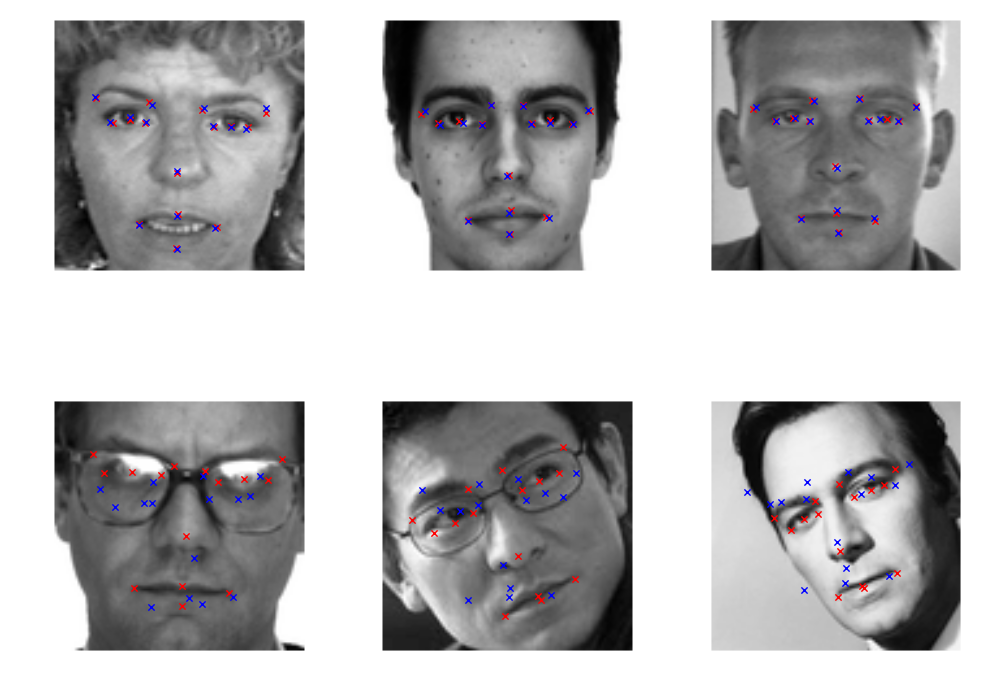

In [47]:
for n in range(1, 4):
    plt.subplot(2, 3, n)
    print(rmse_2_4[n-1][0], rmse_2_4[n-1][1])
    self.plot_example(self.dev_data[rmse_2_4[n-1][0]], self.dev_labels[rmse_2_4[n-1][0]], y_pred[rmse_2_4[n-1][0]], legend=False)
for n in range(1, 4):
    plt.subplot(2, 3, n+3)
    print(rmse_2_4[n*-1][0], rmse_2_4[n*-1][1])
    self.plot_example(self.dev_data[rmse_2_4[n*-1][0]], self.dev_labels[rmse_2_4[n*-1][0]], y_pred[rmse_2_4[n*-1][0]],legend=False)

#### Plot a Prediction

RMSE of 1.30234811633


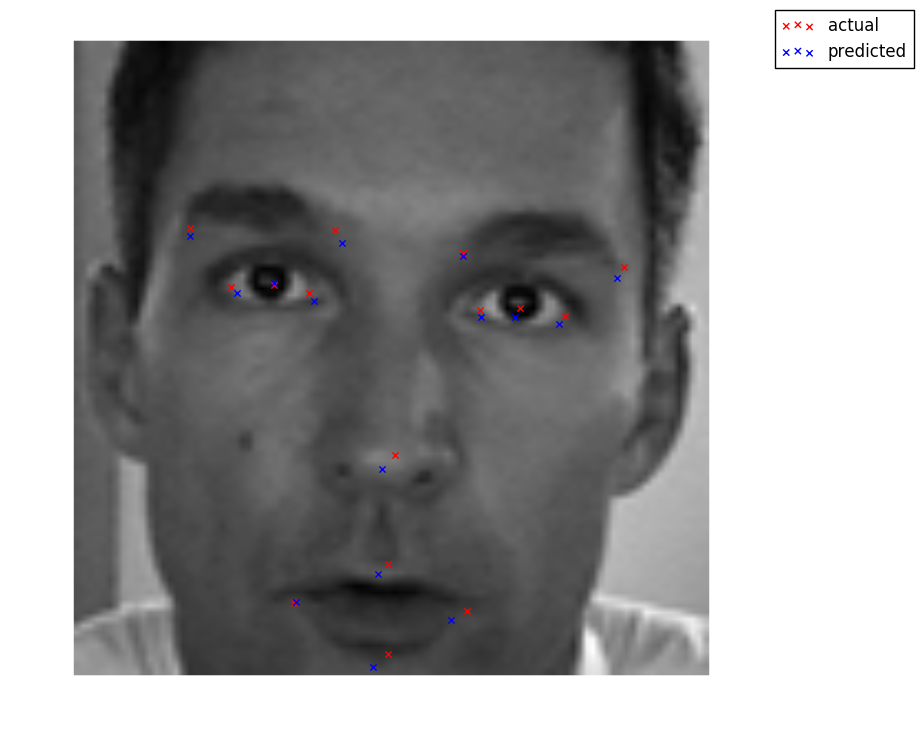

In [45]:
print ('RMSE of '+ str((self.score(self.dev_labels[example_num],
                                   label_scaler.inverse_transform(y_pred[example_num])))))

self.plot_example(self.dev_data[example_num], self.dev_labels[example_num], 
                  label_scaler.inverse_transform(y_pred[example_num]))

#### Examining our Learning Curves

In the above MLP Regression we have the following Learning Curve

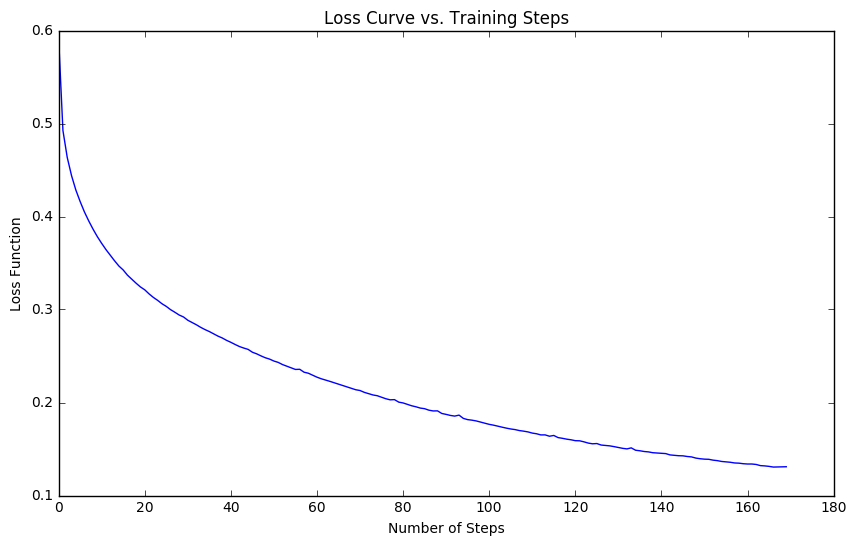

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_)
plt.title('Loss Curve vs. Training Steps')
plt.xlabel('Number of Steps')
plt.ylabel('Loss Function')

In [54]:
labels = self.average_nans(self.train_labels_n)
label_scaler = StandardScaler()
label_scaler.fit(labels)
## Generate submission
mlp_2_4_submission = mlp.predict(data_scaler.transform(self.test_data))
self.submission_gen(label_scaler.inverse_transform(mlp_2_4_submission), 'mlp_2_4')

#### Let's examine a bit closer the Learning Curve using train_test_split

In [50]:
def plot_learning_curves(model, X, y, epoch_size=100):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    
    for m in range(1, X_train.shape[0]/epoch_size):
        model.fit(X_train[:m*epoch_size], y_train[:m*epoch_size])
        y_train_predict = model.predict(X_train[:m*epoch_size])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m*epoch_size]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
        print ('Training Epoch ' + str(m*epoch_size))
        
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='Training Set')
    plt.plot(np.sqrt(val_errors),    'b-', linewidth=3, label='Validation Set')
    plt.title('Loss Curve vs. Training Steps')
    plt.xlabel('Number of Steps')
    plt.ylabel('Loss Function')
    plt.legend()
    return

In [51]:
data = self.train_data
labels = self.train_labels

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp2 = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)

## Warning this can be very slow depending on epoch_size and training data size!!
plot_learning_curves(mlp2, data_scaler.transform(data), label_scaler.transform(labels), epoch_size=50)

TypeError: 'float' object cannot be interpreted as an integer

#### Using Flipped Images to Extend Our Training Data

Flipping the image makes the RMSE worse!

In [52]:
data = np.concatenate((self.train_data, self.train_data_f))
labels = np.concatenate((self.train_labels, self.train_labels_f))

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp2 = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', alpha=0.0001, batch_size='auto', 
             learning_rate='constant', learning_rate_init=0.00012, max_iter=200, shuffle=True, 
             random_state=None, tol=0.0001, verbose=False, early_stopping=False)
mlp2.fit(data_scaler.transform(data), label_scaler.transform(labels))   

C:\Users\Gutwein\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.00012, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [53]:
y_pred = mlp.predict(data_scaler.transform(self.dev_data))
print ('RMSE on Dev Data of ', self.score(self.dev_labels, label_scaler.inverse_transform(y_pred)))

RMSE on Dev Data of  17.2291511214


## Submissions

In [ ]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X=data, y=labels)

k_nn_submission = knn.predict(self.test_data)
self.submission_gen(k_nn_submission, 'knn')

In [ ]:
data = self.blur_data(self.train_data_n)
labels = self.average_nans(self.train_labels_n)

label_scaler, data_scaler = StandardScaler(), StandardScaler()
label_scaler.fit(labels)
data_scaler.fit(data)

mlp = MLPRegressor(hidden_layer_sizes=(1000, 500), early_stopping=True)
mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))   

mlp_submission = mlp.predict(data_scaler.transform(self.test_data))
self.submission_gen(label_scaler.inverse_transform(mlp_submission), 'mlp')

## Appendix A

### Grid Search to Find Best Parameters

Grid searches on both the KNN regressor and the multilayer perceptron regressor are very costly in terms of time. Completing the MLPRegressor grid search was calculated to take up to 33 hours.

In [ ]:
knn = KNeighborsRegressor()
parameters ={'n_neighbors': range(1, 25)}

## Warning Slow
# clf = GridSearchCV(knn, parameters)
# clf.fit(self.train_data, self.train_labels)
# clf.best_params_

In [ ]:
mlp = MLPRegressor()

parameters = {'hidden_layer_sizes': [(500, 200), (1000, 500), (300, 100), (500, 300, 100)],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'alpha': [0.0001, 0.001, 0.01, 0.005],
              'learning_rate': ['constant', 'adaptive'],
              'learning_rate_init': [0.001, 0.005, 0.01, 0.0001],
              'early_stopping': ['True']
              }


## Warning this is VERY SLOW
# clf = GridSearchCV(mlp, parameters)
# clf.fit(self.train_data, self.train_labels)
# clf.best_params_

# Appendix B
Attempts were made with Tensorflow starting with linear regression, then logistics regression, with the goal of transforming the logistic regression model into a mulitlayer neural network. The challenge was in the amount of time needed to build the model as well as incorporating 30 points to be classified. Below are the results of classifying on just one facial keypoint.

## Linear Regression

In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from IPython.display import display, clear_output 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import time
import csv
%matplotlib inline

#### Import and Format Data

In [59]:
# import training.csv which contains a header row of face locations and 'image,' the column of lists of pixel values
with open("../p_final/training.csv") as f:
    train_import = list(csv.reader(f))

# shuffle the data    
removed_header = train_import[1:]
shuffle = np.random.permutation(np.arange(len(removed_header)))
shuffled_train_import = [removed_header[i] for i in shuffle]
    
# divide the rows 80% for training and 20% for development    
train_portion = int(.8*(len(shuffled_train_import)))
dev_portion = len(shuffled_train_import) - train_portion

# extract training and development data
train_data = shuffled_train_import[:train_portion]
dev_data = shuffled_train_import[-dev_portion:]

# initialize the list of lists of pixel values 
train_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(train_data)):
    train_image_data.append([int(i) for i in list(train_data[row][30].split())])
# convert to a numpy array
train_image_data = np.array(train_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
train_image_data = train_image_data/255.0
    
# initialize array of the 30 different facial location target values (labels) for each example image
train_image_labels = np.empty((len(train_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(train_data)):
    for j in range(len(train_data[i][0:30])):
        if train_data[i][j] == '':
            train_image_labels[i][j] = float('nan')
        else: 
            train_image_labels[i][j] = (float(train_data[i][j]))

#### Remove Rows with NaN Target Values

In [60]:
# remove rows where 'left_eye_center_x' == NaN values from the training and label data
non_NaN_list = np.invert((np.isnan(train_image_labels[:,0])))
cln_train_image_data = train_image_data[non_NaN_list]
cln_train_image_labels = train_image_labels[non_NaN_list]

#### Linear Regression - Facial Recognition

In [61]:
tf.reset_default_graph()
trainX = tf.constant(cln_train_image_data, dtype = tf.float32)
# only attempting 1 out of 30 facial locations (column 0), 'left_eye_center_x'
trainY = tf.constant(cln_train_image_labels[:,0], dtype = tf.float32)
learningRate = tf.constant(0.0001)
# create beta variable (vector of 9216 beta values: 1 for each pixel)
beta = tf.get_variable('beta', initializer=np.zeros((9216,1), dtype = np.float32))

def model(this_beta, x):
    return tf.matmul(x, this_beta)

def cost(this_beta):
    ans = tf.reduce_mean((model(this_beta, trainX) - trainY)**2) / 2
    return ans

cc = cost(beta)

## Gradient descent by tensorflow
gd = tf.train.GradientDescentOptimizer(learningRate)
step = gd.minimize(cost(beta))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    cost_vec = []
    # By running step multiple times, we perform gradient descent for the variable beta. 
    # For each step, we can ouput the cost function.
    for i in range(500):
        _, cost = sess.run([step, cc])
        cost_vec.append(cost)
        my_beta = sess.run([beta])[0]
    plt.plot(cost_vec)

KeyboardInterrupt: 

#### Test the Betas with the Development Data

In [ ]:
'''REPEATING SAME TREATMENT OF DATA THAT WAS DONE TO THE TRAINING PORTION'''
# initialize the development list of lists of pixel values 
dev_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(dev_data)):
    dev_image_data.append([int(i) for i in list(dev_data[row][30].split())])
# convert to a numpy array
dev_image_data = np.array(dev_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
dev_image_data = dev_image_data/255.0

# initialize array of the 30 different facial location target values (labels) for each example image
dev_image_labels = np.empty((len(dev_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(dev_data)):
    for j in range(len(dev_data[i][0:30])):
        if dev_data[i][j] == '':
            dev_image_labels[i][j] = float('nan')
        else: 
            dev_image_labels[i][j] = (float(dev_data[i][j]))

#### Remove Rows with NaN Target Values

In [ ]:
# remove rows where 'left_eye_center_x' == NaN values from the dev and dev_label data
non_NaN_list = np.invert((np.isnan(dev_image_labels[:,0])))
cln_dev_image_data = dev_image_data[non_NaN_list]
cln_dev_image_labels = dev_image_labels[non_NaN_list]

#### Calculate RMSE from Development Data

In [57]:
# determine predicted x-coordiate for 'left_eye_center_x', named y_hat to match RMSE formula in Kaggle competition
y_hat = np.matmul(cln_dev_image_data, my_beta)

# y represents the original coordinate for left_eye_center_x'
y = cln_dev_image_labels[:,0]

n = len(y)

# root mean squared error
rmse = np.sqrt(np.sum((y[0] - y_hat)**2)/float(n))

print(rmse)

NameError: name 'cln_dev_image_data' is not defined

## Logistic Regression

In [ ]:
# import training.csv which contains a header row of face locations and 'image,' the column of lists of pixel values
with open("training.csv") as f:
    train_import = list(csv.reader(f))

# shuffle the data    
removed_header = train_import[1:]
shuffle = np.random.permutation(np.arange(len(removed_header)))
shuffled_train_import = [removed_header[i] for i in shuffle]
    
# divide the rows 80% for training and 20% for development    
train_portion = int(.8*(len(shuffled_train_import)))
dev_portion = len(shuffled_train_import) - train_portion

# extract training and development data
train_data = shuffled_train_import[:train_portion]
dev_data = shuffled_train_import[-dev_portion:]

In [ ]:
'''GET TRAINING PIXEL VALUES AND TARGET DATA INTO USABLE NUMPY ARRAYS'''
# initialize the list of lists of pixel values 
train_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(train_data)):
    train_image_data.append([int(i) for i in list(train_data[row][30].split())])
# convert to a numpy array
train_image_data = np.array(train_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
train_image_data = train_image_data/255.0
    
# initialize array of the 30 different facial location target values (labels) for each example image
train_image_labels = np.empty((len(train_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(train_data)):
    for j in range(len(train_data[i][0:30])):
        if train_data[i][j] == '':
            train_image_labels[i][j] = float('nan')
        else: 
            train_image_labels[i][j] = float(train_data[i][j])

In [ ]:
'''REPEATING SAME TREATMENT OF DATA THAT WAS DONE TO THE TRAINING PORTION'''
# initialize the development list of lists of pixel values 
dev_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(dev_data)):
    dev_image_data.append([int(i) for i in list(dev_data[row][30].split())])
# convert to a numpy array
dev_image_data = np.array(dev_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
dev_image_data = dev_image_data/255.0

# initialize array of the 30 different facial location target values (labels) for each example image
dev_image_labels = np.empty((len(dev_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(dev_data)):
    for j in range(len(dev_data[i][0:30])):
        if dev_data[i][j] == '':
            dev_image_labels[i][j] = float('nan')
        else: 
            dev_image_labels[i][j] = (float(dev_data[i][j]))

In [ ]:
# characterizing data set
numFeatures = train_image_data[1].size
numClasses = 96
numTrainExamples = train_image_data.shape[0]
numDevExamples = dev_image_data.shape[0]
print('Features = %d' %(numFeatures))
print('Train set = %d' %(numTrainExamples))
print('Dev set = %d' %(numDevExamples))

#### Remove Rows with NaN Target Values

In [ ]:
# remove rows where 'left_eye_center_x' == NaN values from the training and label data
non_NaN_list = np.invert((np.isnan(train_image_labels[:,0])))
cln_train_image_data = train_image_data[non_NaN_list]
cln_train_image_labels = train_image_labels[non_NaN_list]

# remove rows where 'left_eye_center_x' == NaN values from the dev and dev_label data
non_NaN_list = np.invert((np.isnan(dev_image_labels[:,0])))
cln_dev_image_data = dev_image_data[non_NaN_list]
cln_dev_image_labels = dev_image_labels[non_NaN_list]

#### Logistic Regression - Facial Recognition

In [ ]:
# (1) Parameters

tf.reset_default_graph()

# Constants
devY = tf.one_hot(np.rint(cln_dev_image_labels[:,0]), numClasses)
devX = tf.constant(cln_dev_image_data, dtype = tf.float32)

# placeholders
# In Tensorflow, placeholder are prepared to be filled with different python objects in the session.
# Using these placeholder, we don't need to transform the python objects train_data and train_labels into 
# Tensorflow object. tf.placeholder does this for us.
x_ = tf.placeholder(tf.float32, shape=[None, numFeatures], name='x')
y_ = tf.placeholder(tf.int32, shape=[None], name='y')

# and Variables
w = tf.get_variable('w', shape=[numFeatures, numClasses])

In [ ]:
# (2) Model

def model(input_layer):
    output_layer = tf.nn.softmax(tf.matmul(input_layer, w))
    return output_layer

In [ ]:
# (3) Cost

def cost_func(data, labels):
    cc = tf.losses.mean_squared_error(labels, model(data))
    return  cc

In [ ]:
# (4) Ojbective (and solver)
y_one_hot = tf.one_hot(y_, numClasses)
cc = cost_func(x_, y_one_hot)
gd = tf.train.GradientDescentOptimizer(learning_rate=0.01)
step = gd.minimize(cc)
dev_preds = model(devX)

miniBatchSize = 10;
num_samples = train_image_data.shape[0]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_vec = []
    for i in range(80):
        for start, end in zip(range(0, num_samples, miniBatchSize), range(miniBatchSize, num_samples, miniBatchSize)):
            batch = cln_train_image_data[start:end], np.rint(cln_train_image_labels[:,0][start:end])
            # If we run step in the session, we specify x_ and y_ by using fed_dict as argument
            _, cost, dev__preds = sess.run([step, cc, dev_preds], feed_dict={x_: batch[0], y_: batch[1]})
        cost_vec.append(cost)
        clear_output(wait=True)
        # determine predicted x-coordiate for 'left_eye_center_x', named y_hat to match RMSE formula in competition
        y_hat = np.argmax(dev__preds, axis=1)
        # y represents the original coordinate for left_eye_center_x'
        y = cln_dev_image_labels[:,0]
        n = len(y)
        # root mean squared error
        rmse = np.sqrt(np.sum((y - y_hat)**2)/float(n))
        print('%d) RMSE = %.4f' %(i+1, rmse))
    
plt.plot(cost_vec)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

# Having Some Fun!
Try a 96 pixel by 96 pixel greyscale JPEG yourself.

In [55]:
im = imageio.imread('harry.jpg')

OSError: No such file: 'C:\Users\Gutwein\Google Drive\MIDS\W207 Applied Machine Learning\assignments\W207final_hx_nr_cg\harry.jpg'

In [ ]:
harry_labels_mlp = mlp_blurr.predict(data_scaler.transform(self.rgb2gray(im).reshape(1, 9216)/255.0))
self.plot_example(self.rgb2gray(im)/255.0, label_scaler.inverse_transform(harry_labels_mlp).flatten())